This notebook will be used to create functions that will show the daily veocity plots with data that ahs been calculated every 15 minutes at the VENUS nodes.

#Plotting the Data

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import netCDF4 as nc
from dateutil import tz
import os
from glob import glob

from salishsea_tools import(viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (analyze, figures)
from IPython.display import Image
import datetime

%matplotlib inline

In [42]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'white',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13', 'color' : 'white'}

SITES = {
    'VENUS': {
        'East': {
            'lat': 49.0419,
            'lon': -123.3176,
            'depth': 170,
            'i': 283,
            'j': 416},
        'Central': {
            'lat': 49.0401,
            'lon': -123.4261,
            'depth': 300,
            'i': 266,
            'j': 424}
        }
    }

In [43]:
def axis_colors(ax, plot):
    """Formats the background colour of plots and colours of labels.

    :arg ax: Axis to be formatted.
    :type ax: axis object

    :arg plot: Keyword for background needed for plot.
    :type plot: string

    :returns: axis format
    """

    labels_c = 'white'
    ticks_c = 'white'
    spines_c = 'white'

    if plot == 'blue':
        ax.set_axis_bgcolor('#2B3E50')
    if plot == 'gray':
        ax.set_axis_bgcolor('#DBDEE1')
    if plot == 'white':
        ax.set_axis_bgcolor('white')

    ax.xaxis.label.set_color(labels_c), ax.yaxis.label.set_color(labels_c)
    ax.tick_params(axis='x', colors=ticks_c)
    ax.tick_params(axis='y', colors=ticks_c)
    ax.spines['bottom'].set_color(spines_c)
    ax.spines['top'].set_color(spines_c)
    ax.spines['left'].set_color(spines_c)
    ax.spines['right'].set_color(spines_c)
    ax.title.set_color('white')

    return ax

In [44]:
def results_dataset_gridded( station, results_dir):
    """Return the results dataset for station (e.g. central or east)
     for the quarter hourly data from results_dir.
    """
        
    filename_pattern = 'VENUS_{station}_gridded.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(station=station)))
    return nc.Dataset(filepaths[0])


In [82]:
run_date=datetime.date(2015, 5, )

# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())


In [83]:
grid_c=results_dataset_gridded('central',results_dir)
grid_e=results_dataset_gridded('east',results_dir)

IndexError: list index out of range

In [81]:
def unstag_rot_gridded(ugrid, vgrid, station):
    """Interpolate u and v component values to values at grid cell centre.
    Then rotates the grid cells to align with N/E orientation.

    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`

    :arg station: Name of the station ('East' or 'Central')
    :type station: string

    :returns u_E, v_N, depths: u_E and v_N velocties is the North and East
     directions at the cell center,
    and the depth of the station
    """

    # We need to access the u velocity that is between i and i-1
    u_t = (ugrid[:, :, 1, 0] + ugrid[:, :, 1, 1]) / 2
    v_t = (vgrid[:, :, 1, 1] + vgrid[:, :, 0, 1]) / 2
    theta = 29
    theta_rad = theta * np.pi / 180

    u_E = u_t * np.cos(theta_rad) - v_t * np.sin(theta_rad)
    v_N = u_t * np.sin(theta_rad) + v_t * np.cos(theta_rad)

    return u_E, v_N

In [76]:
def plot_vel_NE_gridded(station, grid, figsize=(14, 8)):
    """Plots the hourly averaged North/South and East/West velocities at a chosen
    VENUS node station using data that is calculated every 15 minutes.

    :arg station: Name of the station ('East' or 'Central')
    :type station: string

    :arg grid: Quarter-hourly velocity and tracer results dataset from NEMO.
    :type grid: :class:`netCDF4.Dataset`

    :arg figsize: Figure size (width, height) in inches or 'default'.
    :type figsize: 2-tuple

    :returns: matplotlib figure object instance (fig).
    """
    u_u = grid.variables['vozocrtx']
    v_v = grid.variables['vomecrty']
    w_w = grid.variables['vovecrtz']
    dep_t = grid.variables['depthv']
    dep_w = grid.variables['depthw']

    u_E, v_N = unstag_rot_gridded(u_u, v_v, station)
    fig, (axu, axv) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    fig.patch.set_facecolor('#2B3E50')
    
    max_array = np.maximum(abs(v_N),abs(u_E))
    max_speed = np.amax(max_array)
    
    vmax= max_speed
    vmin = - max_speed
    step = 0.03

    # viz_tools.set_aspect(axu)
    timestamp = nc_tools.timestamp(grid, 0)
    cmap = plt.get_cmap('jet')
    dep_s = SITES['VENUS'][station]['depth']

    axu.invert_yaxis()
    mesh = axu.contourf(
        np.arange(0, 24, 0.25),
        dep_t[:],
        u_E.transpose(),
        np.arange(vmin, vmax, step), cmap=cmap)
    cbar = fig.colorbar(mesh, ax=axu)
    axu.set_ylim([dep_s, 0])
    axu.set_xlim([0, 23])
    axu.set_ylabel('Depth [m]', **axis_font)
    figures.axis_colors(axu, 'white')
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(
        node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('[m/s]', **axis_font)

    axv.invert_yaxis()
    mesh = axv.contourf(
        np.arange(0, 24, 0.25),
        dep_t[:],
        v_N.transpose(),
        np.arange(vmin, vmax, step),
        cmap=cmap)
    cbar = fig.colorbar(mesh, ax=axv)
    axv.set_ylim([dep_s, 0])
    axv.set_xlim([0, 23])
    axv.set_ylabel('Depth [m]', **axis_font)
    figures.axis_colors(axv, 'white')
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(
        node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('[m/s]', **axis_font)

  #  axw.invert_yaxis()
  #  mesh = axw.contourf(
  #      np.arange(0, 24, 0.25), dep_w[:],
  #      w_w[:, :, 1, 1].transpose(),
  #      np.arange(vmin/70, vmax/70, step/80),
  #      cmap=cmap)
  #  cbar = fig.colorbar(mesh, ax=axw)
  # axw.set_ylim([dep_s, 0])
  # axw.set_xlim([0, 23])
  # axw.set_xlabel('Time [h]', **axis_font)
  #  axw.set_ylabel('Depth [m]', **axis_font)
  # figures.axis_colors(axw, 'white')
  # axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(
  #     node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font)
   # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
   # cbar.set_label('[m/s]', **axis_font)



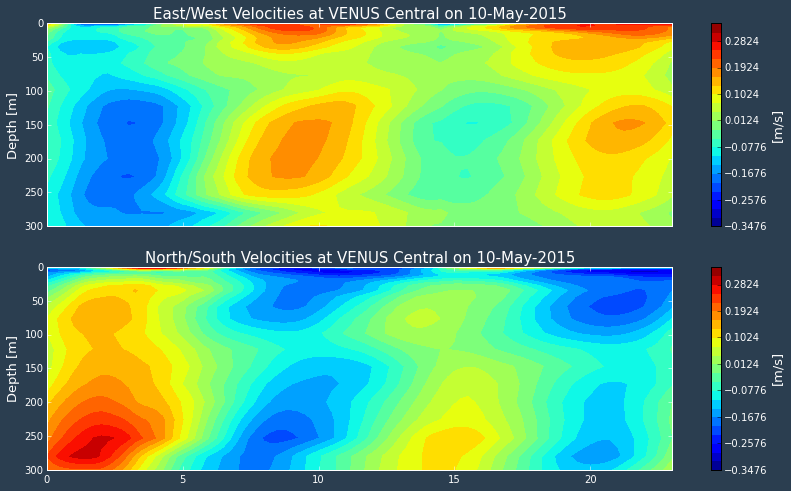

In [77]:
plot_vel_NE_gridded('Central', grid_c)

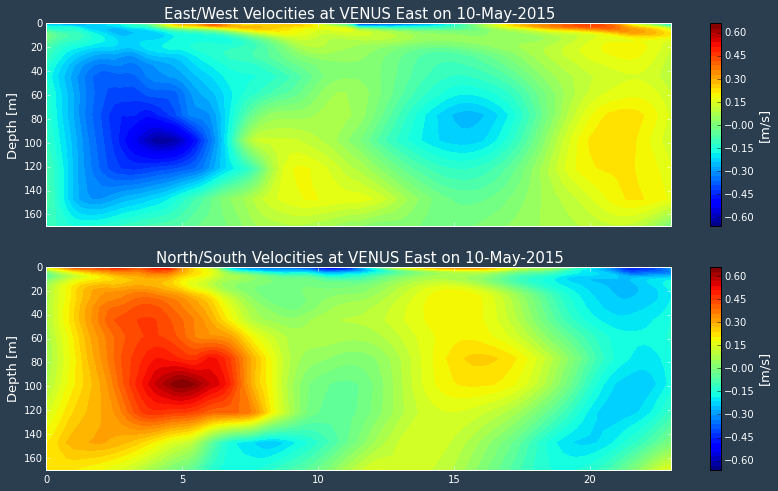

In [78]:
plot_vel_NE_gridded('East', grid_e)

#Showing the nodes on a map
The plots say they are evaluted at VENUS however someone looking at these plots could use a map to visualise where these nodes are located to have a better idea of what we are showing with the plots

In [63]:
fileb='/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
grid_B=nc.Dataset(fileb)

In [64]:
location = {'Vancouver': {'lat': 49.2827,'lon': -123.1207}}
t=0
zlevel=0


In [65]:
def VENUS_location(grid_B, figsize=(10,10)):
    """Plots the location of the VENUS Central and East nodes as well as 
    Vancouver as a reference on a bathymetry map.
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg figsize: Figure size (width, height) in inches.
    :type figsize: 2-tuple
    
    :returns: matplotlib figure object instance (fig).
    """
    
    lats = grid_B.variables['nav_lat'][:]
    lons = grid_B.variables['nav_lon'][:]
    bathy = grid_B.variables['Bathymetry'][:]

    #plotting
    fig,ax=plt.subplots(1,1,figsize=figsize)
    fig.patch.set_facecolor('#2B3E50')
    viz_tools.plot_coastline(ax,grid_B,coords='map')
    viz_tools.set_aspect(ax)
    cmap = plt.get_cmap('winter_r')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(lons, lats, bathy, cmap=cmap)
    cbar = fig.colorbar(mesh)


    lon_c=SITES['VENUS']['Central']['lon']
    lat_c=SITES['VENUS']['Central']['lat']
    lon_e=SITES['VENUS']['East']['lon']
    lat_e=SITES['VENUS']['East']['lat']
    lon_v=location['Vancouver']['lon']
    lat_v=location['Vancouver']['lat']

    ax.plot(lon_c, lat_c, marker='D', color='Black',markersize=10, markeredgewidth=2)
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
    ax.annotate('Central', (lon_c - 0.15, lat_c + 0.08), fontsize=15,color='black', bbox=bbox_args)

    ax.plot(lon_e, lat_e, marker='D', color='Black',markersize=10, markeredgewidth=2)
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
    ax.annotate('East', (lon_e + 0.05, lat_e + 0.08), fontsize=15,color='black', bbox=bbox_args)

    ax.plot(lon_v, lat_v, marker='D', color='DarkMagenta',markersize=10, markeredgewidth=2)
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
    ax.annotate('Vancouver', (lon_v - 0.15, lat_v + 0.08), fontsize=15,color='black', bbox=bbox_args)

    ax.set_xlim([-124.02,-123.02])
    ax.set_ylim([48.5,49.6])
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    figures.axis_colors(ax, 'white')
    ax.set_xlabel('Longitude',**axis_font)
    ax.set_ylabel('Latitude', **axis_font)
    ax.set_title('VENUS Node Locations', **title_font)    
    cbar.set_label('Depth [m]', **axis_font)
    return fig

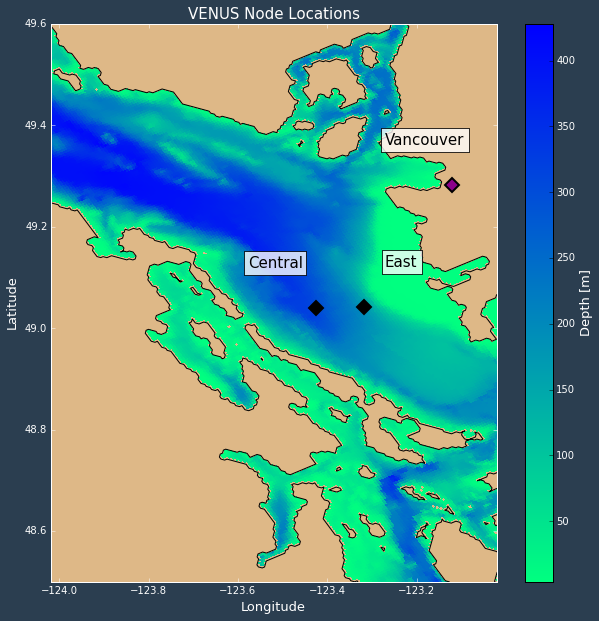

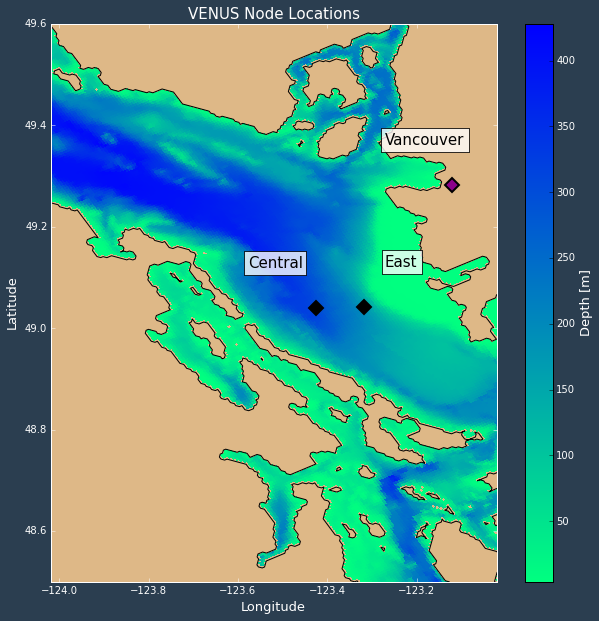

In [66]:
VENUS_location(grid_B)